<table class="m01-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/yy/netsci-course/blob/master/m10-epidemics/m10-networkepidemiology.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/yy/netsci-course/blob/master/m10-epidemics/m10-networkepidemiology.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on Github</a>
  </td>
</table>

# Network epidemiology

The goal of this assignment is to implement a working SIS model on a network and reproduce a figure from this week's readings. We will start with an SI model as a template which you can then expand upon to build the SIS model.

## SI model

We will put together a function that will be able to take as input networkx graphs. In the SI model, a fraction of nodes begin as infected and then new infections spread throughout the network across the links with some probability $\beta$. If the dice rolls out of the nodes favor then it becomes infected and can then infect other nodes that it neighbors.

In a connected graph, the SI model should eventually infect everyone as $t \rightarrow \infty$ because there will always be a non-zero probability of transmission. Alternatively, the SIS model will reach an equilibrium point where there is a balance between infections and reversions to susceptibility.

Let's build the SI model!

In [2]:
# We will be using numpy and networkx for our function
import networkx as nx
import numpy as np

The simulation first requires a network. Once a network is given, we can then randomly choose a small fraction of initially infected nodes. We also need to keep track of every node's state (infected or susceptible). In each time step, we go through every node and figure out what would be the next state of the node based on its current state and neighbors. For instance, if the node is already infected, then it will remain infected regardless of the states of the neighbors (SI model). 

We can play with each step first. Let's first create a network. 

In [4]:
G = nx.barabasi_albert_graph(10**4, 5)

We can create an attribute to store the nodes' states. 

In [7]:
nx.set_node_attributes(G, {node: [0] for node in G.nodes()}, 'inf')
G.nodes[0]['inf']

[0]

We are using a list to store the state so that we can keep a time-series of every node's state. This also makes the simulation easier. 

Now we can randomly choose a certain fraction of nodes and mark them as initially infected using `choice()` function in numpy. 

In [10]:
init_infected_fraction = 0.001
init_infected = set(np.random.choice(G.nodes(), 
                                     size=int(len(G) * init_infected_fraction), 
                                     replace=False))
init_infected

{1455, 3868, 3878, 5390, 5753, 7700, 7901, 8819, 9000, 9647}

We should set these nodes' states to be `1` and then we can begin the simulation. 

In [11]:
for node in init_infected:
    G.nodes[node]['inf'][0] = 1
G.nodes[1455]['inf']

[1]

But how should we update the states and run the simulation? 

There is an important issue here. If we immediately change the state of a particular node, that may affect the updating of other nodes! Imagine an extreme case where we are simulating a highly infectious disease on a chain-like network where node 0 is connected to node 1, node 1 is connected to node 0 and 2, and so on. In the simulation we are going through each node one by one from node 0 to node N and update them immediately. But it happens to be that node 0 was infected. Then, it can propagate to many nodes within a single time step because it is possible that node 1 gets updated to be infected by node 0, and then node 2 gets infected by node 1, and so on. This is clearly unrealistic. 

If we change a node's state, then the next node will be updating with respect to a network that is now in a different state!

When modelling discrete-time dynamical systems there are generally two different update strategies: synchronous and asynchronous updating. In the asynchronous updating, a random node is picked and its state is updated according to the current network state. In the synchronous updating, there is a global time clock that all nodes are synced to, so nodes only update according to the state of the network at the _current time-step_ and all nodes move to the next time step simultaneously.    

Choosing the updating scheme can have a huge impact on dynamics. We will be using the synchronous updating scheme, which means we need to store the _next state_ of the system before updating everyone all at once. There are many ways to accomplish this, but for the sake of simplicity, we will just keep the whole history. 

In [12]:
def run_SI(graph, tmax: int, beta: float, initial_inf: float):
    """Runs the SI model on the given graph with given parameters. 

    Parameters
    ----------
    graph : networkx graph object
        The network (graph) on which the simulation will be run
    tmax : int
        The maximum time step that we will run the model 
    beta : float
        The transmission probability
    initial_inf : float
        The initial fraction of infected nodes

    Returns
    -------
    list[float]
        the time-series of the fraction of infected nodes
    """
    # First lets generate a set of initially infected nodes.
    init_infected = set(
        np.random.choice(graph.nodes(), size=int(len(graph) * initial_inf), replace=False)
    )
    
    # The code below uses a dictionary comprehension to generate a dictionary
    # with keys=nodes and values=a list of 0's and 1's. The 1 is for infected
    # and 0 is for susceptible. We then give that dictionary to networkx's
    # attribute function which then gives all the nodes the 'inf' attribute.
    nx.set_node_attributes(
        graph, 
        {node: ([1] if node in init_infected else [0]) for node in graph.nodes()},
        'inf'
    )
    
    # Now we need to loop through for `tmax` time step. One time step equals to 
    # updating the whole network once. 
    for t in range(tmax):
        for node in graph.nodes():
            
            # Now we check if the node if susceptible to infection
            # If it is, we need to determine the probability of it switching
            # and then switch it for the next time-step
            if graph.nodes[node]['inf'][t] == 0:
                
                # First determine how many infected neighbors the node has at time t:
                num_inf_neighbors = np.sum(
                    [ graph.nodes[neighbor]['inf'][t] for neighbor in graph.neighbors(node)]
                )
                
                # Instead of drawing a bunch of random numbers for each neighbor
                # we can just calculate the cumulative probability of getting
                # infected since these events are independent and then just
                # draw 1 random number to check against:
                if np.random.random() < (1 - (1 - beta)**num_inf_neighbors):
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other 
                    # nodes update, because they will be using time index t not t+1
                    graph.nodes[node]['inf'].append(1)
                    
                else:
                    # If no infection occurs, then just append the current state (0)
                    graph.nodes[node]['inf'].append(0)
                    
            # Similarly, if the node is already infected it can't change back
            # So we append the current state if it wasn't susceptible
            else:
                graph.nodes[node]['inf'].append(1)
    # the function returns a time series of the fraction of infected in each time step.             
    return [ np.mean([ graph.nodes[node]['inf'][t] for node in graph.nodes() ]) for t in range(tmax)]

And there we have our SI model. The function is mostly comments, there are only a dozen lines of code involved in the whole process. Lets give it a run:

In [13]:
# Lets generate a random graph for testing
rnd_graph = nx.erdos_renyi_graph(100, 0.1)

# We want to make sure that the graph is connected, so we will only take the largest
# connected component, as disconnected parts can't be infected or transmit infection:
largest_component = max(nx.connected_components(rnd_graph), key=len)
# above returns a set of nodes, so we use it to creat a subgraph
largest_component = rnd_graph.subgraph(largest_component)

In [15]:
nx.info(largest_component)

'Graph with 100 nodes and 486 edges'

Now we can run it and plot it. 

In [16]:
import matplotlib.pyplot as plt

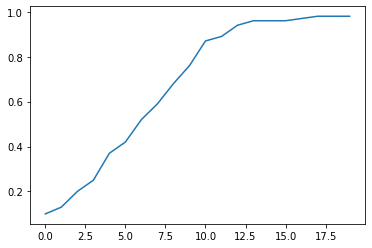

In [18]:
plt.plot(run_SI(largest_component, tmax=20, beta=0.05, initial_inf=0.1))

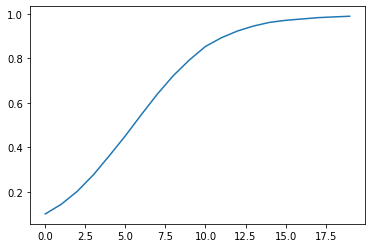

In [19]:
# Since it is a random process we want to do a couple
# sample runs to smooth out the curve

plt.plot( np.mean([run_SI(rnd_graph, tmax=20, beta=0.05, initial_inf=0.1) for i in range(50)], axis=0) )

The axis argument in `numpy.mean` tells you which axis to apply the average over, since we have a two-dimensional array (time on one axis and trials on the other). If I picked `axis=1` instead, it would have run the average over time rather than the number of trials.

This curve is much smoother than the previous one. You will find that this sort of averaging over trials is necessary when dealing with noisy or random models.

We can see that at 10% initial infected population and an infection rate of 5% we infect the whole 100 node network within 20 time steps. Most of the growth occurs in the middle after the disease ramps up, and then slows as most of the population is already infected.

## Building the SIS model
The example SI model should give you a good starting point from which to create the SIS version. In the SIS model, infected nodes can transform back to susceptible nodes, which means you will have one additional parameter that needs to be provided as an argument to the model. Lets call this probability of reversion `mu`.  

The SI model implementation is simple but far from optimal, it will be slower to run on larger and more dense graphs. If you want more of a challenge try comming up with an SIS version that can run efficiently on larger graphs. This could be done by relying more heavily on numpy by vectorizing operations and/or by using other faster libraries. 

Here are your goals:

1. Create an SIS version of the function.
2. Plot your model's results using a sparse random graph and play with the parameters to get a feel for how `mu`, `beta`, and `initial_inf` change the equilibrium point of the system. The equilibrium point occurs when the system settles on a stable fraction of infected (see Fig 10.7 in Barabasi's textbook). Also take note of how long it takes for the system to reach equilibrium.
3. Finally, construct a graph like the figure from Barabasi's book that shows the difference between Erdos-Renyi graphs and Scale-free graphs for the SIS-model. The Y-axis in the figure will be the equilibrium point of the system. This will generally be the last time point of your simulation, assuming you run it long enough to let it reach equilibrium. The X-axis is the parameter `lambda` which is just `beta / mu`. The exact location of the critical point for the SIS model on the ER graph will vary depending upon parameters, but the key take-away is that the Scale-free graph's is lower (and eventually vanishes depending upon scaling exponent). Lastly, remember to use averaging to smooth the curves over many trials for each data-point. Note: The BA algorithm only generates exponents of 3. You can generate a directed scale-free graph with varying power-law exponent using networkx's [`scafe_free_graph`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.directed.scale_free_graph.html?%20scale_free_graph#networkx.generators.directed.scale_free_graph) function. However, it needs to be converted to an undirected graph. You can make a power-law exponent of ~2.5 with the following parameters `alpha=0.35`, `beta=0.60`, `gamma=0.05`, `delta_in=0.4`, `delta_out=0.4`

4. When you are done submit your notebook to Canvas.